In [1]:
import pandas as pd
import polars as pl
from data import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from missforest import MissForest
import pickle
import joblib
from lightgbm import LGBMClassifier, LGBMRegressor
import pyarrow
import sklearn
from sklearn.svm import SVR, LinearSVR
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import json
import numpy as np
import shap
from scipy import stats
from typing import Any, cast, Final
from utils import *
import wrds
from xgboost import XGBRegressor

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Fetching missing data

## 1.1. Reading all the predictor values

In [2]:
full_data = pl.read_csv(get_data_file_path("signed_predictors_all_wide.csv"), schema_overrides=SIGNED_PREDICTORS_ENTRY_SCHEMA)
full_data = full_data.sort(by=["yyyymm", "permno"], maintain_order=True)
full_data.insert_column(2, full_data["yyyymm"].str.to_date("%Y%m").alias("date"))
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,Spinoff,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,"""192512""",1925-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-4.691348,-11.088278
10014,"""192512""",1925-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null
10022,"""192512""",1925-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-4.025352,-9.323669
10030,"""192512""",1925-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-5.010635,-10.060491
10049,"""192512""",1925-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-4.304065,-9.825526
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
85272,"""202410""",2024-10-01,null,null,null,-0.082707,null,null,null,null,null,null,null,null,-0.574621,null,null,null,null,null,null,null,null,-1.298188,null,null,null,null,null,null,-0.792602,-1.482673,null,-0.110388,null,null,…,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,-0.216307,null,null,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
88841,"""202410""",2024-10-01,null,null,0.046021,0.070207,null,null,null,null,null,null,null,null,0.085084,null,null,null,null,null,null,null,null,-1.26169,null,null,null,null,null,null,0.053662,-1.112958,null,0.0,null,null,…,null,null,1.1701046,-0.039176,null,null,null,null,null,null,0.135177,null,null,null,0.048669,null,null,null,null,null,0.04735,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
89986,"""202410""",2024-10-01,null,null,0.567842,0.43184

In [3]:
full_data = full_data.filter((pl.col("date") >= date(1972, 11, 1)) & (pl.col("date") <= date(2023, 12, 31)))
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,Spinoff,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,"""197211""",1972-11-01,1.8323255,null,-0.036283,0.032336,null,null,null,0.005684,null,null,null,0.0123,-0.057118,-0.448801,0.8793962,-0.534452,0.677534,1.2002188,0.198674,0.238189,0.000732,-1.962242,-250.17551,0.119151,0.142407,null,null,16.849766,-0.052076,-1.016543,null,0.012778,0.055488,null,…,0.0,0.0,0.563577,-0.008061,0.1265153,null,-0.000475,-0.021764,-0.053608,0.017403,-0.007177,null,-0.052639,null,-0.044096,null,null,null,0.1166129,-0.828235,0.105059,null,null,-0.345847,null,null,null,null,null,null,0.756519,1.5528e-7,2.4302e-7,1.0906e-7,6.253,-3.881564,-12.51155
10014,"""197211""",1972-11-01,2.3547554,null,0.094414,0.173883,1.0,null,null,null,null,null,null,0.106299,0.100548,-0.090451,1.0505323,0.102736,1.163693,2.7982018,-0.036606,0.13817,0.023141,-1.854014,null,0.232317,0.177941,null,null,5.5586514,0.402247,-1.067354,null,0.116868,-0.253702,null,…,0.0,null,2.1719143,-0.01237,null,null,-0.004438,-0.041131,-0.096768,0.034901,0.034257,null,0.40707,null,0.109633,null,null,null,-0.208027,-0.958571,0.222222,null,null,-0.234734,null,0.008438,null,null,null,-0.022901,0.641664,1.4204e-7,1.5426e-7,9.6808e-8,0.0,-1.252763,-9.73267
10023,"""197211""",1972-11-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null
10057,"""197211""",1972-11-01,1.3478317,null,-0.05239,0.050687,null,null,null,null,null,null,null,0.016536,0.04082,0.139893,1.1787429,-0.011189,0.590555,1.023692,-0.011247,0.260488,0.008738,-1.394205,null,0.134335,0.038479,null,0.022156,6.0799537,-0.343798,-0.945671,null,0.024256,0.493721,null,…,0.0,null,2.4113321,0.030292,0.118428,null,-0.004626,-0.00944,-0.015783,-0.005582,0.007154,null,-0.033149,null,0.024986,null,null,null,0.530716,-0.456507,0.135553,null,null,-0.044186,null,null,null,null,null,-0.004108,0.783954,2.5927e-7,3.2529e-7,2.4176e-7,-18.8034,-2.855032,-11.109301
10058,"""197211""",1972-11-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93426,"""202312""",2023-12-01,null,null,-0.037102,0.005406,null,null,null,null,null,null,null,null,-0.032157,null,null,null,null,null,null,null,null,-1.534121,null,null,null,null,null,null,-0.036009,-1.106272,null,-0.017543,null,null,…,null,1.0,0.830135,-0.052671,null,null,null,null,null,null,0.006658,null,null,null,-0.042883,null,null,null,null,null,-0.037736,nu

## 1.4. Joining the returns with the original data

In [5]:
all_returns_data = pl.read_csv(get_data_file_path("1_3_all_returns_values.csv"), schema_overrides={"yyyymm": pl.String, "date": pl.Date})
all_returns_data

permno,yyyymm,date,ret
i64,str,date,f64
10000,"""198601""",1986-01-31,0.707317
10000,"""198602""",1986-02-28,-0.257143
10000,"""198603""",1986-03-31,0.365385
10000,"""198604""",1986-04-30,-0.098592
10000,"""198605""",1986-05-30,-0.222656
…,…,…,…
93436,"""202308""",2023-08-31,-0.034962
93436,"""202309""",2023-09-29,-0.030456
93436,"""202310""",2023-10-31,-0.197346


In [6]:
full_data = full_data.join(all_returns_data, on=("yyyymm", "permno"))
full_data = full_data.sort(by=["yyyymm", "permno"], maintain_order=True).drop("date_right")
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,"""197211""",1972-11-01,1.8323255,null,-0.036283,0.032336,null,null,null,0.005684,null,null,null,0.0123,-0.057118,-0.448801,0.8793962,-0.534452,0.677534,1.2002188,0.198674,0.238189,0.000732,-1.962242,-250.17551,0.119151,0.142407,null,null,16.849766,-0.052076,-1.016543,null,0.012778,0.055488,null,…,0.0,0.563577,-0.008061,0.1265153,null,-0.000475,-0.021764,-0.053608,0.017403,-0.007177,null,-0.052639,null,-0.044096,null,null,null,0.1166129,-0.828235,0.105059,null,null,-0.345847,null,null,null,null,null,null,0.756519,1.5528e-7,2.4302e-7,1.0906e-7,6.253,-3.881564,-12.51155,-0.062289
10014,"""197211""",1972-11-01,2.3547554,null,0.094414,0.173883,1.0,null,null,null,null,null,null,0.106299,0.100548,-0.090451,1.0505323,0.102736,1.163693,2.7982018,-0.036606,0.13817,0.023141,-1.854014,null,0.232317,0.177941,null,null,5.5586514,0.402247,-1.067354,null,0.116868,-0.253702,null,…,null,2.1719143,-0.01237,null,null,-0.004438,-0.041131,-0.096768,0.034901,0.034257,null,0.40707,null,0.109633,null,null,null,-0.208027,-0.958571,0.222222,null,null,-0.234734,null,0.008438,null,null,null,-0.022901,0.641664,1.4204e-7,1.5426e-7,9.6808e-8,0.0,-1.252763,-9.73267,0.0
10057,"""197211""",1972-11-01,1.3478317,null,-0.05239,0.050687,null,null,null,null,null,null,null,0.016536,0.04082,0.139893,1.1787429,-0.011189,0.590555,1.023692,-0.011247,0.260488,0.008738,-1.394205,null,0.134335,0.038479,null,0.022156,6.0799537,-0.343798,-0.945671,null,0.024256,0.493721,null,…,null,2.4113321,0.030292,0.118428,null,-0.004626,-0.00944,-0.015783,-0.005582,0.007154,null,-0.033149,null,0.024986,null,null,null,0.530716,-0.456507,0.135553,null,null,-0.044186,null,null,null,null,null,-0.004108,0.783954,2.5927e-7,3.2529e-7,2.4176e-7,-18.8034,-2.855032,-11.109301,0.188034
10065,"""197211""",1972-11-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.530412,1.0972391,-0.03315,null,0.008889,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,-0.006325,-0.015328,-0.005452,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.3752e-7,4.2518e-7,3.1820e-7,-6.6667,-2.639057,-12.043648,0.066667
10102,"""197211""",1972-11-01,2.8037627,null,-0.006352,0.034338,null,null,null,null,null,null,null,0.021162,-0.033163,0.091918,1.4261148,9.0310478,0.800822,2.0441911,-0.106429,0.245022,0.007959,-1.705458,null,0.116609,0.220319,null,null,18.190111,-0.007461,-1.04883,null,-0.031813,0.408558,null,…,0.0,0.154531,-0.009669,0.137479,null,-0.001911,-0.03019,-0.173491,0.000127,0.017115,null,-0.071019,null,-0.001587,null,null,null,0.417722,-0.689695,0.036699,null,null,-0.213956,null,null,null,null,null,null,0.751193,1.3238e-7,5.9608e-8,1.1357e-7,-6.2774,-2.890372,-12.245505,0.062938
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93426,"""202312""",2023-12-01,null,null,-0.037102,0.005406,null,null,null,null,null,null,null,nul

<hr>

# 2. Analysis and cleaning of full dataset

## 2.1 Analysis

### Retrieving the previously computed data and analyzing it

In [2]:
full_data = pl.read_csv(get_data_file_path("1_4_complete_dataset.csv"), schema_overrides=ALL_DATA_WITH_DATES_ENTRY_SCHEMA)

### Summary statistics

In [3]:
full_data.describe()

statistic,permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4.336216e6,"""4336216""","""4336216""",2.701919e6,1.15785e6,2.306086e6,2.771079e6,207586.0,108731.0,30170.0,1.000076e6,323539.0,1.831642e6,1.15785e6,2.780251e6,2.7843e6,2.438787e6,2.693432e6,2.684341e6,3.512052e6,3.100346e6,3.095873e6,1.818359e6,3.598072e6,3.06388e6,427502.0,2.082973e6,2.701919e6,665346.0,2.003163e6,2.680822e6,2.104545e6,2.67381e6,598245.0,2.784342e6,2.390269e6,…,1.364324e6,2.719508e6,2.659375e6,1.521609e6,443513.0,2.276411e6,3.527007e6,3.161132e6,2.940102e6,2.718347e6,3.141841e6,2.462629e6,797950.0,2.782229e6,797950.0,797950.0,840921.0,2.173951e6,1.989513e6,3.024389e6,1.56695e6,1.567902e6,1.343777e6,707340.0,2.387078e6,561785.0,169945.0,458208.0,1.735953e6,1.248277e6,3.65754e6,3.800056e6,3.435317e6,4.336192e6,4.231072e6,4.231072e6,4.257839e6
"""null_count""",0.0,"""0""","""0""",1.634297e6,3.178366e6,2.03013e6,1.565137e6,4.12863e6,4.227485e6,4.306046e6,3.33614e6,4.012677e6,2.504574e6,3.178366e6,1.555965e6,1.551916e6,1.897429e6,1.642784e6,1.651875e6,824164.0,1.23587e6,1.240343e6,2.517857e6,738144.0,1.272336e6,3.908714e6,2.253243e6,1.634297e6,3.67087e6,2.333053e6,1.655394e6,2.231671e6,1.662406e6,3.737971e6,1.551874e6,1.945947e6,…,2.971892e6,1.616708e6,1.676841e6,2.814607e6,3.892703e6,2.059805e6,809209.0,1.175084e6,1.396114e6,1.617869e6,1.194375e6,1.873587e6,3.538266e6,1.553987e6,3.538266e6,3.538266e6,3.495295e6,2.162265e6,2.346703e6,1.311827e6,2.769266e6,2.768314e6,2.992439e6,3.628876e6,1.949138e6,3.774431e6,4.166271e6,3.878008e6,2.600263e6,3.087939e6,678676.0,536160.0,900899.0,24.0,105144.0,105144.0,78377.0
"""mean""",57080.739158,null,"""1999-12-31""",3.848548,-167.987622,-0.002061,0.030441,0.483987,14.8865,9.263089,0.074976,18.541335,1.006447,0.761476,0.00266,-0.188596,-0.743404,3.01391,0.013737,0.98804,0.918899,0.000125,0.692003,0.017482,-4.170478,-2657.91128,0.092546,-0.000261,-0.009441,0.163805,14.093706,-0.125069,-1.322929,0.4765,-0.010104,-62.293334,…,0.286724,1.145398,-0.007906,0.189363,0.352181,-0.939135,-0.194164,-5.517591,-0.006062,-0.062583,-0.00046,0.005568,0.000138,-0.103481,0.000396,-0.000534,-16.736662,-3.572018,8.4534e10,-0.041708,1.725571,1.59892,-4.3991e-11,0.010877,-0.007347,0.005598,0.188255,-0.067404,-0.193662,0.687651,1.314702,1.39393,1.244107,-0.922302,-2.417701,inf,0.009535
"""std""",28865.438233,null,null,28.203881,49157.458375,0.149632,0.126656,0.499745,2.724359,12.642133,0.362023,22.924938,4.870561,1.531836,0.10091,2.898215,1.054689,54.417337,346.132937,0.774412,0.613358,0.458023,0.527905,0.032428,208.642116,73351.332682,0.218522,2.468889,0.063112,0.210359,4033.676255,299.183141,13.968044,0.499448,0.065337,1.0644e13,…,0.452232,19.838503,0.814822,0.158552,0.477651,56.471506,1.780256,38.873511,0.020741,0.488792,0.017131,1.525522,0.193816,2.031764,0.182771,0.185065,12.008629,355.983617,4.4808e13,0.274167,5.96922,5.223386,0.2498,0.083283,0.2915,1.49462,0.390917,0.084423,2.696227,0.18742,3.141981,3.505349,2.956663,17.507306,1.30549,NaN,0.177517
"""min""",10000.0,"""197211""","""1972-11-01""",0.0,-1.5267176e7,-2.809462,-11.61904

### Number of nulls in each column

In [4]:
full_data.null_count()

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,1634297,3178366,2030130,1565137,4128630,4227485,4306046,3336140,4012677,2504574,3178366,1555965,1551916,1897429,1642784,1651875,824164,1235870,1240343,2517857,738144,1272336,3908714,2253243,1634297,3670870,2333053,1655394,2231671,1662406,3737971,1551874,1945947,4142529,…,2971892,1616708,1676841,2814607,3892703,2059805,809209,1175084,1396114,1617869,1194375,1873587,3538266,1553987,3538266,3538266,3495295,2162265,2346703,1311827,2769266,2768314,2992439,3628876,1949138,3774431,4166271,3878008,2600263,3087939,678676,536160,900899,24,105144,105144,78377


### Percentage of non-null elements in each column

In [5]:
full_data.count() / len(full_data)

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,1.0,0.623105,0.267019,0.53182,0.639055,0.047873,0.025075,0.006958,0.230633,0.074613,0.422406,0.267019,0.64117,0.642104,0.562423,0.621148,0.619051,0.809935,0.714989,0.713957,0.419342,0.829772,0.706579,0.098589,0.480367,0.623105,0.153439,0.461961,0.61824,0.485341,0.616623,0.137965,0.642113,0.551234,0.044667,…,0.314635,0.627162,0.613294,0.350907,0.102281,0.524976,0.813384,0.729007,0.678034,0.626894,0.724558,0.567921,0.18402,0.641626,0.18402,0.18402,0.19393,0.501347,0.458813,0.697472,0.361363,0.361583,0.309896,0.163124,0.550498,0.129557,0.039192,0.10567,0.400338,0.287872,0.843487,0.876353,0.792238,0.999994,0.975752,0.975752,0.981925


## 2.2 Cleaning of nulls

In [3]:
def null_percentage(row: tuple[Any], /, *, discount_rows: int) -> float:
    return (row.count(None) - discount_rows) / (len(row) - discount_rows)

In [8]:
def compute_avg_nulls_for_row(df: pl.DataFrame, /) -> pl.DataFrame:
    assert len(frozenset(df["permno"].to_list())) == 1, "Not groupped properly"
    return pl.DataFrame(
        {
            "permno": df["permno"][0],
            "null_avg": full_data.filter(pl.col("permno") == df["permno"][0]).map_rows(lambda x: null_percentage(x, discount_rows=3)).max().item()
        }
    )

In [9]:
null_avg_per_permno = full_data.sort(by="permno", maintain_order=True).group_by("permno").map_groups(compute_avg_nulls_for_row)
null_avg_per_permno

permno,null_avg
i64,f64
10000,0.901408
10001,0.892019
10002,0.892019
10003,0.915493
10004,0.971831
…,…
93432,0.882629
93433,0.920188
93434,0.967136


In [13]:
full_data_filtered = full_data.join(null_avg_per_permno, on="permno").filter(pl.col("null_avg") < 0.7).drop("null_avg")
full_data_filtered

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,"""197211""",1972-11-01,1.8323255,null,-0.036283,0.032336,null,null,null,0.005684,null,null,null,0.0123,-0.057118,-0.448801,0.8793962,-0.534452,0.677534,1.2002188,0.198674,0.238189,0.000732,-1.962242,-250.17551,0.119151,0.142407,null,null,16.849766,-0.052076,-1.016543,null,0.012778,0.055488,null,…,0.0,0.563577,-0.008061,0.1265153,null,-0.000475,-0.021764,-0.053608,0.017403,-0.007177,null,-0.052639,null,-0.044096,null,null,null,0.1166129,-0.828235,0.105059,null,null,-0.345847,null,null,null,null,null,null,0.756519,1.5528e-7,2.4302e-7,1.0906e-7,6.253,-3.881564,-12.51155,-0.062289
10057,"""197211""",1972-11-01,1.3478317,null,-0.05239,0.050687,null,null,null,null,null,null,null,0.016536,0.04082,0.139893,1.1787429,-0.011189,0.590555,1.023692,-0.011247,0.260488,0.008738,-1.394205,null,0.134335,0.038479,null,0.022156,6.0799537,-0.343798,-0.945671,null,0.024256,0.493721,null,…,null,2.4113321,0.030292,0.118428,null,-0.004626,-0.00944,-0.015783,-0.005582,0.007154,null,-0.033149,null,0.024986,null,null,null,0.530716,-0.456507,0.135553,null,null,-0.044186,null,null,null,null,null,-0.004108,0.783954,2.5927e-7,3.2529e-7,2.4176e-7,-18.8034,-2.855032,-11.109301,0.188034
10102,"""197211""",1972-11-01,2.8037627,null,-0.006352,0.034338,null,null,null,null,null,null,null,0.021162,-0.033163,0.091918,1.4261148,9.0310478,0.800822,2.0441911,-0.106429,0.245022,0.007959,-1.705458,null,0.116609,0.220319,null,null,18.190111,-0.007461,-1.04883,null,-0.031813,0.408558,null,…,0.0,0.154531,-0.009669,0.137479,null,-0.001911,-0.03019,-0.173491,0.000127,0.017115,null,-0.071019,null,-0.001587,null,null,null,0.417722,-0.689695,0.036699,null,null,-0.213956,null,null,null,null,null,null,0.751193,1.3238e-7,5.9608e-8,1.1357e-7,-6.2774,-2.890372,-12.245505,0.062938
10137,"""197211""",1972-11-01,2.5459855,null,null,0.027129,null,null,null,null,null,null,null,null,-0.139167,-0.206667,0.915123,0.991262,0.407149,0.9622348,0.185535,0.11099,0.004587,-3.00343,null,0.101711,0.183784,null,null,null,-0.00106,-1.171195,null,0.0,-0.101887,null,…,null,null,-0.049463,0.135322,null,-0.000578,-0.016434,-0.182967,-0.01723,null,null,null,null,-0.135809,null,null,null,-0.226138,-1.321246,0.047864,null,null,null,null,0.011556,null,null,null,null,null,1.7613e-7,1.6566e-7,1.6979e-7,-4.7826,-3.167583,-13.192934,0.047826
10153,"""197211""",1972-11-01,5.5199385,null,0.020123,0.030114,null,null,null,null,null,null,null,0.000359,-0.016832,0.876893,2.584492,-3.84988,0.981295,2.0460491,0.258777,0.393041,0.007624,-2.197402,null,0.06999,0.186662,null,null,20.77861,-0.166211,-0.998554,null,0.000248,0.194191,null,…,null,1.9892853,0.008897,0.125256,null,-0.015985,-0.030949,-0.225708,0.013632,0.035974,null,-0.066308,null,0.011324,null,null,null,0.161825,-0.788444,0.106019,null,null,-0.004539,null,null,null,null,null,null,null,7.8204e-8,1.0005e-7,8.3266e-8,-12.6316,-2.593387,-11.861053,0.126316
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2113

### Get percentage of non-null elements in each column

In [14]:
full_data_filtered.count() / len(full_data_filtered)

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,1.0,0.991314,0.375896,0.962337,0.995418,0.064513,0.060069,0.007508,0.38773,0.000172,0.574772,0.375896,0.969763,0.995418,0.950933,0.994524,0.990555,0.997707,0.993079,0.991773,0.931568,0.997176,0.998446,0.204058,0.920652,0.991314,0.087318,0.743816,0.985181,0.960611,0.978538,0.200017,0.995418,0.984763,0.036987,…,0.462264,0.923885,0.988629,0.706232,0.066489,0.98693,0.993056,0.996635,0.993204,0.920646,0.377882,0.96519,0.095459,0.99522,0.095459,0.095459,0.309071,0.978066,0.967579,0.998446,0.301688,0.301401,0.46741,0.180277,0.848288,0.139427,0.070668,0.056233,0.314135,0.587291,0.998087,0.998459,0.997714,1.0,0.99487,0.99487,0.999964


In [15]:
(full_data_filtered.count() / len(full_data_filtered)).transpose().filter(pl.col("column_0") < 0.5).count()

column_0
u32
71


### Saving cleaned dataset to the `/data` folder

In [68]:
full_data_filtered.write_csv(get_data_file_path("new_run/2_2_cleaned_dataset.csv"))

## 2.3 Removing permnos with few rows

In [2]:
full_data = pl.read_csv(get_data_file_path("new_run/2_2_cleaned_dataset.csv"), schema_overrides=ALL_DATA_WITH_DATES_ENTRY_SCHEMA)
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,"""197211""",1972-11-01,1.8323255,null,-0.036283,0.032336,null,null,null,0.005684,null,null,null,0.0123,-0.057118,-0.448801,0.8793962,-0.534452,0.677534,1.2002188,0.198674,0.238189,0.000732,-1.962242,-250.17551,0.119151,0.142407,null,null,16.849766,-0.052076,-1.016543,null,0.012778,0.055488,null,…,0.0,0.563577,-0.008061,0.1265153,null,-0.000475,-0.021764,-0.053608,0.017403,-0.007177,null,-0.052639,null,-0.044096,null,null,null,0.1166129,-0.828235,0.105059,null,null,-0.345847,null,null,null,null,null,null,0.756519,1.5528e-7,2.4302e-7,1.0906e-7,6.253,-3.881564,-12.51155,-0.062289
10014,"""197211""",1972-11-01,2.3547554,null,0.094414,0.173883,1.0,null,null,null,null,null,null,0.106299,0.100548,-0.090451,1.0505323,0.102736,1.163693,2.7982018,-0.036606,0.13817,0.023141,-1.854014,null,0.232317,0.177941,null,null,5.5586514,0.402247,-1.067354,null,0.116868,-0.253702,null,…,null,2.1719143,-0.01237,null,null,-0.004438,-0.041131,-0.096768,0.034901,0.034257,null,0.40707,null,0.109633,null,null,null,-0.208027,-0.958571,0.222222,null,null,-0.234734,null,0.008438,null,null,null,-0.022901,0.641664,1.4204e-7,1.5426e-7,9.6808e-8,0.0,-1.252763,-9.73267,0.0
10057,"""197211""",1972-11-01,1.3478317,null,-0.05239,0.050687,null,null,null,null,null,null,null,0.016536,0.04082,0.139893,1.1787429,-0.011189,0.590555,1.023692,-0.011247,0.260488,0.008738,-1.394205,null,0.134335,0.038479,null,0.022156,6.0799537,-0.343798,-0.945671,null,0.024256,0.493721,null,…,null,2.4113321,0.030292,0.118428,null,-0.004626,-0.00944,-0.015783,-0.005582,0.007154,null,-0.033149,null,0.024986,null,null,null,0.530716,-0.456507,0.135553,null,null,-0.044186,null,null,null,null,null,-0.004108,0.783954,2.5927e-7,3.2529e-7,2.4176e-7,-18.8034,-2.855032,-11.109301,0.188034
10102,"""197211""",1972-11-01,2.8037627,null,-0.006352,0.034338,null,null,null,null,null,null,null,0.021162,-0.033163,0.091918,1.4261148,9.0310478,0.800822,2.0441911,-0.106429,0.245022,0.007959,-1.705458,null,0.116609,0.220319,null,null,18.190111,-0.007461,-1.04883,null,-0.031813,0.408558,null,…,0.0,0.154531,-0.009669,0.137479,null,-0.001911,-0.03019,-0.173491,0.000127,0.017115,null,-0.071019,null,-0.001587,null,null,null,0.417722,-0.689695,0.036699,null,null,-0.213956,null,null,null,null,null,null,0.751193,1.3238e-7,5.9608e-8,1.1357e-7,-6.2774,-2.890372,-12.245505,0.062938
10137,"""197211""",1972-11-01,2.5459855,null,null,0.027129,null,null,null,null,null,null,null,null,-0.139167,-0.206667,0.915123,0.991262,0.407149,0.9622348,0.185535,0.11099,0.004587,-3.00343,null,0.101711,0.183784,null,null,null,-0.00106,-1.171195,null,0.0,-0.101887,null,…,null,null,-0.049463,0.135322,null,-0.000578,-0.016434,-0.182967,-0.01723,null,null,null,null,-0.135809,null,null,null,-0.226138,-1.321246,0.047864,null,null,null,null,0.011556,null,null,null,null,null,1.7613e-7,1.6566e-7,1.6979e-7,-4.7826,-3.167583,-13.192934,0.047826
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93426,

In [17]:
full_data = full_data.join(full_data.group_by("permno").len(), on="permno")
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret,len
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32
10006,"""197211""",1972-11-01,1.8323255,null,-0.036283,0.032336,null,null,null,0.005684,null,null,null,0.0123,-0.057118,-0.448801,0.8793962,-0.534452,0.677534,1.2002188,0.198674,0.238189,0.000732,-1.962242,-250.17551,0.119151,0.142407,null,null,16.849766,-0.052076,-1.016543,null,0.012778,0.055488,null,…,0.563577,-0.008061,0.1265153,null,-0.000475,-0.021764,-0.053608,0.017403,-0.007177,null,-0.052639,null,-0.044096,null,null,null,0.1166129,-0.828235,0.105059,null,null,-0.345847,null,null,null,null,null,null,0.756519,1.5528e-7,2.4302e-7,1.0906e-7,6.253,-3.881564,-12.51155,-0.062289,140
10057,"""197211""",1972-11-01,1.3478317,null,-0.05239,0.050687,null,null,null,null,null,null,null,0.016536,0.04082,0.139893,1.1787429,-0.011189,0.590555,1.023692,-0.011247,0.260488,0.008738,-1.394205,null,0.134335,0.038479,null,0.022156,6.0799537,-0.343798,-0.945671,null,0.024256,0.493721,null,…,2.4113321,0.030292,0.118428,null,-0.004626,-0.00944,-0.015783,-0.005582,0.007154,null,-0.033149,null,0.024986,null,null,null,0.530716,-0.456507,0.135553,null,null,-0.044186,null,null,null,null,null,-0.004108,0.783954,2.5927e-7,3.2529e-7,2.4176e-7,-18.8034,-2.855032,-11.109301,0.188034,285
10102,"""197211""",1972-11-01,2.8037627,null,-0.006352,0.034338,null,null,null,null,null,null,null,0.021162,-0.033163,0.091918,1.4261148,9.0310478,0.800822,2.0441911,-0.106429,0.245022,0.007959,-1.705458,null,0.116609,0.220319,null,null,18.190111,-0.007461,-1.04883,null,-0.031813,0.408558,null,…,0.154531,-0.009669,0.137479,null,-0.001911,-0.03019,-0.173491,0.000127,0.017115,null,-0.071019,null,-0.001587,null,null,null,0.417722,-0.689695,0.036699,null,null,-0.213956,null,null,null,null,null,null,0.751193,1.3238e-7,5.9608e-8,1.1357e-7,-6.2774,-2.890372,-12.245505,0.062938,67
10137,"""197211""",1972-11-01,2.5459855,null,null,0.027129,null,null,null,null,null,null,null,null,-0.139167,-0.206667,0.915123,0.991262,0.407149,0.9622348,0.185535,0.11099,0.004587,-3.00343,null,0.101711,0.183784,null,null,null,-0.00106,-1.171195,null,0.0,-0.101887,null,…,null,-0.049463,0.135322,null,-0.000578,-0.016434,-0.182967,-0.01723,null,null,null,null,-0.135809,null,null,null,-0.226138,-1.321246,0.047864,null,null,null,null,0.011556,null,null,null,null,null,1.7613e-7,1.6566e-7,1.6979e-7,-4.7826,-3.167583,-13.192934,0.047826,460
10153,"""197211""",1972-11-01,5.5199385,null,0.020123,0.030114,null,null,null,null,null,null,null,0.000359,-0.016832,0.876893,2.584492,-3.84988,0.981295,2.0460491,0.258777,0.393041,0.007624,-2.197402,null,0.06999,0.186662,null,null,20.77861,-0.166211,-0.998554,null,0.000248,0.194191,null,…,1.9892853,0.008897,0.125256,null,-0.015985,-0.030949,-0.225708,0.013632,0.035974,null,-0.066308,null,0.011324,null,null,null,0.161825,-0.788444,0.106019,null,null,-0.004539,null,null,null,null,null,null,null,7.8204e-8,1.0005e-7,8.3266e-8,-12.6316,-2.593387,-11.861053,0.126316,194
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
21135,"""202203

In [18]:
full_data = full_data.filter(pl.col("len") >= 101).drop("len")
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,"""197211""",1972-11-01,1.8323255,null,-0.036283,0.032336,null,null,null,0.005684,null,null,null,0.0123,-0.057118,-0.448801,0.8793962,-0.534452,0.677534,1.2002188,0.198674,0.238189,0.000732,-1.962242,-250.17551,0.119151,0.142407,null,null,16.849766,-0.052076,-1.016543,null,0.012778,0.055488,null,…,0.0,0.563577,-0.008061,0.1265153,null,-0.000475,-0.021764,-0.053608,0.017403,-0.007177,null,-0.052639,null,-0.044096,null,null,null,0.1166129,-0.828235,0.105059,null,null,-0.345847,null,null,null,null,null,null,0.756519,1.5528e-7,2.4302e-7,1.0906e-7,6.253,-3.881564,-12.51155,-0.062289
10057,"""197211""",1972-11-01,1.3478317,null,-0.05239,0.050687,null,null,null,null,null,null,null,0.016536,0.04082,0.139893,1.1787429,-0.011189,0.590555,1.023692,-0.011247,0.260488,0.008738,-1.394205,null,0.134335,0.038479,null,0.022156,6.0799537,-0.343798,-0.945671,null,0.024256,0.493721,null,…,null,2.4113321,0.030292,0.118428,null,-0.004626,-0.00944,-0.015783,-0.005582,0.007154,null,-0.033149,null,0.024986,null,null,null,0.530716,-0.456507,0.135553,null,null,-0.044186,null,null,null,null,null,-0.004108,0.783954,2.5927e-7,3.2529e-7,2.4176e-7,-18.8034,-2.855032,-11.109301,0.188034
10137,"""197211""",1972-11-01,2.5459855,null,null,0.027129,null,null,null,null,null,null,null,null,-0.139167,-0.206667,0.915123,0.991262,0.407149,0.9622348,0.185535,0.11099,0.004587,-3.00343,null,0.101711,0.183784,null,null,null,-0.00106,-1.171195,null,0.0,-0.101887,null,…,null,null,-0.049463,0.135322,null,-0.000578,-0.016434,-0.182967,-0.01723,null,null,null,null,-0.135809,null,null,null,-0.226138,-1.321246,0.047864,null,null,null,null,0.011556,null,null,null,null,null,1.7613e-7,1.6566e-7,1.6979e-7,-4.7826,-3.167583,-13.192934,0.047826
10153,"""197211""",1972-11-01,5.5199385,null,0.020123,0.030114,null,null,null,null,null,null,null,0.000359,-0.016832,0.876893,2.584492,-3.84988,0.981295,2.0460491,0.258777,0.393041,0.007624,-2.197402,null,0.06999,0.186662,null,null,20.77861,-0.166211,-0.998554,null,0.000248,0.194191,null,…,null,1.9892853,0.008897,0.125256,null,-0.015985,-0.030949,-0.225708,0.013632,0.035974,null,-0.066308,null,0.011324,null,null,null,0.161825,-0.788444,0.106019,null,null,-0.004539,null,null,null,null,null,null,null,7.8204e-8,1.0005e-7,8.3266e-8,-12.6316,-2.593387,-11.861053,0.126316
10161,"""197211""",1972-11-01,1.7504586,null,-0.018167,0.010192,null,null,null,null,null,null,null,0.023021,-0.174806,-0.201734,1.0100162,-0.087229,0.393118,1.0487787,-0.350323,0.197598,0.002452,-1.855797,null,0.058332,0.131097,null,null,3.8422475,-0.265739,-1.025307,null,-0.015168,1.2863349,null,…,null,-0.128159,-0.010985,0.135037,null,-0.000672,-0.013121,-0.099637,-0.009957,-0.075018,null,-0.013477,null,-0.100623,null,null,null,0.236755,-1.061528,0.017804,null,null,null,null,null,null,null,null,null,0.641311,1.8790e-7,1.7655e-7,1.6620e-7,-6.8996,-3.409496,-13.481375,0.069468
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2

### Make sure data is still sorted by date

In [19]:
full_data.sort("date", maintain_order=True).equals(full_data)

True

In [20]:
(full_data.count() / len(full_data)).transpose().filter(pl.col("column_0") < 0.5).count()

column_0
u32
71


### Write to output and make sure no corruption

In [21]:
full_data.write_csv(get_data_file_path("new_run_2/2_3_cleaned_dataset.csv"))
pl.read_csv(get_data_file_path("new_run_2/2_3_cleaned_dataset.csv"), schema_overrides=ALL_DATA_WITH_DATES_ENTRY_SCHEMA).equals(full_data)

True

<hr>

# 3. Imputation and normalization of data

## 3.1. Defining the miss forest implementation

### Retrieving data from the previous section

In [22]:
full_data = pd.read_csv(get_data_file_path("new_run_2/2_3_cleaned_dataset.csv"))
full_data

,permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,NaN,-0.036283,0.032336,NaN,NaN,NaN,...,NaN,NaN,0.756519,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.062289
1,10057,197211,1972-11-01,1.347832,NaN,-0.052390,0.050687,NaN,NaN,NaN,...,NaN,-0.004108,0.783954,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,0.188034
2,10137,197211,1972-11-01,2.545986,NaN,NaN,0.027129,NaN,NaN,NaN,...,NaN,NaN,NaN,1.761280e-07,1.656610e-07,1.697866e-07,-4.7826,-3.167583,-13.192934,0.047826
3,10153,197211,1972-11-01,5.519939,NaN,0.020123,0.030114,NaN,NaN,NaN,...,NaN,NaN,NaN,7.820356e-08,1.000459e-07,8.326582e-08,-12.6316,-2.593387,-11.861053,0.126316
4,10161,197211,1972-11-01,1.750459,NaN,-0.018167,0.010192,NaN,NaN,NaN,...,NaN,NaN,0.641311,1.879001e-07,1.765456e-07,1.661959e-07,-6.8996,-3.409496,-13.481375,0.069468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281675,21135,202203,2022-03-01,1.078565,-3.202294,-0.130023,0.024767,NaN,NaN,NaN,...,NaN,NaN,0.450277,1.743680e-08,1.915919e-08,1.726693e-08,-0.0460,-3.079154,-14.413300,0.000460
281676,41574,202203,2022-03-01,0.546924,-4.157743,0.004075,0.028303,NaN,NaN,NaN,...,NaN,-0.110614,0.672704,2.303368e-08,1.130542e-08,2.265321e-08,0.2925,-3.172203,-12.309435,-0.002925
281677,21135,202204,2022-04-01,NaN,-3.202294,-0.130023,0.024767,NaN,NaN,NaN,...,NaN,NaN,0.450277,1.692520e-08,7.626886e-09,1.683881e-08,-1.1960,NaN,NaN,0.011960
281678,41574,202204,2022-04-01,0.543098,-4.157743,0.004075,0.028303,NaN,NaN,NaN,...,NaN,-0.104201,0.672704,1.868144e-08,4.371318e-09,2.211234e-08,-0.6287,-3.178470,-12.316455,0.006287


### Defining the miss forest imputation function

In [23]:
NON_VALUE_ATTRIBUTES = ["permno", "yyyymm", "date"]

def miss_forest_impute(df: pd.DataFrame, /, *, n_estimators: int, seed: int = 0) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan, inplace=False)
    dropped_df = df.drop(columns=NON_VALUE_ATTRIBUTES)
    imputer = MissForest(
        n_estimators=n_estimators,
        random_state=seed,
        criterion=("squared_error", "gini"),
        max_features="sqrt",
        verbose=False
    )
    return pd.concat([df[NON_VALUE_ATTRIBUTES], pd.DataFrame(imputer.fit_transform(dropped_df), columns=dropped_df.columns)], axis=1)

## 3.2. Executing the miss forest implementation

### Running the function on our cleaned dataset

<p style="color: #FFC107">⚠️ WARNING: The execution of the function takes over 5 hours.</p>

In [24]:
full_data_imputed = miss_forest_impute(full_data, n_estimators=10)
full_data_imputed

Iteration: 0
Iteration: 1


,permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,-0.499786,-0.036283,0.032336,0.7,14.8,10.387030,...,-0.085564,-0.012577,0.756519,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.062289
1,10057,197211,1972-11-01,1.347832,-3.510633,-0.052390,0.050687,0.8,15.2,4.946596,...,-0.156928,-0.004108,0.783954,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,0.188034
2,10137,197211,1972-11-01,2.545986,-0.183893,-0.013736,0.027129,0.8,14.9,8.094886,...,-0.186548,-0.012332,0.573537,1.761280e-07,1.656610e-07,1.697866e-07,-4.7826,-3.167583,-13.192934,0.047826
3,10153,197211,1972-11-01,5.519939,-1.799259,0.020123,0.030114,1.0,14.0,6.047968,...,-0.061780,-0.028855,0.678508,7.820356e-08,1.000459e-07,8.326582e-08,-12.6316,-2.593387,-11.861053,0.126316
4,10161,197211,1972-11-01,1.750459,-0.559730,-0.018167,0.010192,0.5,14.3,6.063848,...,-0.124403,-0.013955,0.641311,1.879001e-07,1.765456e-07,1.661959e-07,-6.8996,-3.409496,-13.481375,0.069468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281675,21135,202203,2022-03-01,1.078565,-3.202294,-0.130023,0.024767,0.5,12.5,8.275961,...,-0.195728,-0.132854,0.450277,1.743680e-08,1.915919e-08,1.726693e-08,-0.0460,-3.079154,-14.413300,0.000460
281676,41574,202203,2022-03-01,0.546924,-4.157743,0.004075,0.028303,0.2,14.2,13.052074,...,-0.179027,-0.110614,0.672704,2.303368e-08,1.130542e-08,2.265321e-08,0.2925,-3.172203,-12.309435,-0.002925
281677,21135,202204,2022-04-01,3.162694,-3.202294,-0.130023,0.024767,0.7,14.1,7.917191,...,-0.095084,-0.079703,0.450277,1.692520e-08,7.626886e-09,1.683881e-08,-1.1960,-3.625160,-14.522550,0.011960
281678,41574,202204,2022-04-01,0.543098,-4.157743,0.004075,0.028303,0.2,15.2,13.848089,...,-0.223900,-0.104201,0.672704,1.868144e-08,4.371318e-09,2.211234e-08,-0.6287,-3.178470,-12.316455,0.006287


### Saving the result to the `data/` directory

In [25]:
#full_data_imputed.to_csv(get_data_file_path("new_run_2/3_2_imputed_dataset.csv"))
full_data_imputed.to_parquet(get_data_file_path("new_run_2/3_2_imputed_dataset.parquet"), engine="pyarrow", index=False)

### Making sure the file writing was correct

In [27]:
full_data_imputed.equals(pd.read_parquet(get_data_file_path("new_run_2/3_2_imputed_dataset.parquet"), engine="pyarrow"))

True

## 3.3. Analysis of results

### Reading imputed data from file

In [28]:
# full_data_imputed = pl.read_csv(get_data_file_path("3_2_imputed_dataset.csv")).drop("").to_pandas()
full_data_imputed = pd.read_parquet(get_data_file_path("new_run_2/3_2_imputed_dataset.parquet"), engine="pyarrow")

### Make sure there are no missing values

In [29]:
has_any_na(full_data_imputed)

False

## 3.4. Shifting Returns

### For each permno, shift returns up one row

In [31]:
full_data_imputed_rectified = full_data_imputed.copy()
assert full_data_imputed_rectified.equals(full_data_imputed), "Data frame copy failed!"
full_data_imputed_rectified["ret"] = full_data_imputed.groupby("permno")["ret"].shift(-1)
full_data_imputed_rectified

,permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,-0.499786,-0.036283,0.032336,0.7,14.8,10.387030,...,-0.085564,-0.012577,0.756519,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.018041
1,10057,197211,1972-11-01,1.347832,-3.510633,-0.052390,0.050687,0.8,15.2,4.946596,...,-0.156928,-0.004108,0.783954,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,-0.021583
2,10137,197211,1972-11-01,2.545986,-0.183893,-0.013736,0.027129,0.8,14.9,8.094886,...,-0.186548,-0.012332,0.573537,1.761280e-07,1.656610e-07,1.697866e-07,-4.7826,-3.167583,-13.192934,0.031579
3,10153,197211,1972-11-01,5.519939,-1.799259,0.020123,0.030114,1.0,14.0,6.047968,...,-0.061780,-0.028855,0.678508,7.820356e-08,1.000459e-07,8.326582e-08,-12.6316,-2.593387,-11.861053,-0.080075
4,10161,197211,1972-11-01,1.750459,-0.559730,-0.018167,0.010192,0.5,14.3,6.063848,...,-0.124403,-0.013955,0.641311,1.879001e-07,1.765456e-07,1.661959e-07,-6.8996,-3.409496,-13.481375,0.086777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281675,21135,202203,2022-03-01,1.078565,-3.202294,-0.130023,0.024767,0.5,12.5,8.275961,...,-0.195728,-0.132854,0.450277,1.743680e-08,1.915919e-08,1.726693e-08,-0.0460,-3.079154,-14.413300,0.011960
281676,41574,202203,2022-03-01,0.546924,-4.157743,0.004075,0.028303,0.2,14.2,13.052074,...,-0.179027,-0.110614,0.672704,2.303368e-08,1.130542e-08,2.265321e-08,0.2925,-3.172203,-12.309435,0.006287
281677,21135,202204,2022-04-01,3.162694,-3.202294,-0.130023,0.024767,0.7,14.1,7.917191,...,-0.095084,-0.079703,0.450277,1.692520e-08,7.626886e-09,1.683881e-08,-1.1960,-3.625160,-14.522550,NaN
281678,41574,202204,2022-04-01,0.543098,-4.157743,0.004075,0.028303,0.2,15.2,13.848089,...,-0.223900,-0.104201,0.672704,1.868144e-08,4.371318e-09,2.211234e-08,-0.6287,-3.178470,-12.316455,0.009996


### Remove last rows for each permno (returns will be nulls due to shifting)

In [32]:
full_data_imputed_rectified = full_data_imputed_rectified.dropna()
full_data_imputed_rectified

,permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,-0.499786,-0.036283,0.032336,0.7,14.8,10.387030,...,-0.085564,-0.012577,0.756519,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.018041
1,10057,197211,1972-11-01,1.347832,-3.510633,-0.052390,0.050687,0.8,15.2,4.946596,...,-0.156928,-0.004108,0.783954,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,-0.021583
2,10137,197211,1972-11-01,2.545986,-0.183893,-0.013736,0.027129,0.8,14.9,8.094886,...,-0.186548,-0.012332,0.573537,1.761280e-07,1.656610e-07,1.697866e-07,-4.7826,-3.167583,-13.192934,0.031579
3,10153,197211,1972-11-01,5.519939,-1.799259,0.020123,0.030114,1.0,14.0,6.047968,...,-0.061780,-0.028855,0.678508,7.820356e-08,1.000459e-07,8.326582e-08,-12.6316,-2.593387,-11.861053,-0.080075
4,10161,197211,1972-11-01,1.750459,-0.559730,-0.018167,0.010192,0.5,14.3,6.063848,...,-0.124403,-0.013955,0.641311,1.879001e-07,1.765456e-07,1.661959e-07,-6.8996,-3.409496,-13.481375,0.086777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281672,21135,202202,2022-02-01,1.090629,-3.202294,-0.130023,0.024767,0.5,12.5,7.125605,...,-0.253000,-0.128758,0.450277,1.962614e-08,1.893219e-08,1.841384e-08,0.3211,-3.078694,-14.402176,0.000460
281674,41574,202202,2022-02-01,0.546618,-4.157743,0.004075,0.028303,0.2,15.5,13.076174,...,-0.285379,-0.110237,0.672704,2.759027e-08,4.561268e-08,2.442423e-08,-63.5680,-3.175133,-12.309995,-0.002925
281675,21135,202203,2022-03-01,1.078565,-3.202294,-0.130023,0.024767,0.5,12.5,8.275961,...,-0.195728,-0.132854,0.450277,1.743680e-08,1.915919e-08,1.726693e-08,-0.0460,-3.079154,-14.413300,0.011960
281676,41574,202203,2022-03-01,0.546924,-4.157743,0.004075,0.028303,0.2,14.2,13.052074,...,-0.179027,-0.110614,0.672704,2.303368e-08,1.130542e-08,2.265321e-08,0.2925,-3.172203,-12.309435,0.006287


### Cleanup

In [33]:
full_data_imputed_rectified = full_data_imputed_rectified.reset_index(drop=True)
full_data_imputed_rectified

,permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,-0.499786,-0.036283,0.032336,0.7,14.8,10.387030,...,-0.085564,-0.012577,0.756519,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.018041
1,10057,197211,1972-11-01,1.347832,-3.510633,-0.052390,0.050687,0.8,15.2,4.946596,...,-0.156928,-0.004108,0.783954,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,-0.021583
2,10137,197211,1972-11-01,2.545986,-0.183893,-0.013736,0.027129,0.8,14.9,8.094886,...,-0.186548,-0.012332,0.573537,1.761280e-07,1.656610e-07,1.697866e-07,-4.7826,-3.167583,-13.192934,0.031579
3,10153,197211,1972-11-01,5.519939,-1.799259,0.020123,0.030114,1.0,14.0,6.047968,...,-0.061780,-0.028855,0.678508,7.820356e-08,1.000459e-07,8.326582e-08,-12.6316,-2.593387,-11.861053,-0.080075
4,10161,197211,1972-11-01,1.750459,-0.559730,-0.018167,0.010192,0.5,14.3,6.063848,...,-0.124403,-0.013955,0.641311,1.879001e-07,1.765456e-07,1.661959e-07,-6.8996,-3.409496,-13.481375,0.086777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280565,21135,202202,2022-02-01,1.090629,-3.202294,-0.130023,0.024767,0.5,12.5,7.125605,...,-0.253000,-0.128758,0.450277,1.962614e-08,1.893219e-08,1.841384e-08,0.3211,-3.078694,-14.402176,0.000460
280566,41574,202202,2022-02-01,0.546618,-4.157743,0.004075,0.028303,0.2,15.5,13.076174,...,-0.285379,-0.110237,0.672704,2.759027e-08,4.561268e-08,2.442423e-08,-63.5680,-3.175133,-12.309995,-0.002925
280567,21135,202203,2022-03-01,1.078565,-3.202294,-0.130023,0.024767,0.5,12.5,8.275961,...,-0.195728,-0.132854,0.450277,1.743680e-08,1.915919e-08,1.726693e-08,-0.0460,-3.079154,-14.413300,0.011960
280568,41574,202203,2022-03-01,0.546924,-4.157743,0.004075,0.028303,0.2,14.2,13.052074,...,-0.179027,-0.110614,0.672704,2.303368e-08,1.130542e-08,2.265321e-08,0.2925,-3.172203,-12.309435,0.006287


### Sanity Check

In [34]:
has_any_na(full_data_imputed_rectified)

False

### Save to Files

In [35]:
#full_data_imputed_rectified.to_csv(get_data_file_path("new_run_2/3_4_ready_dataset.csv"))
full_data_imputed_rectified.to_parquet(get_data_file_path("new_run_2/3_4_ready_dataset.parquet"), engine="pyarrow", index=False)

### Check there is no data loss

In [36]:
full_data_imputed_rectified.equals(read_from_parquet("new_run_2/3_4_ready_dataset.parquet"))

True

<hr>

# 4. Training

In [37]:
full_data_imputed = read_from_parquet("new_run_2/3_4_ready_dataset.parquet")
full_data_imputed

,permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,-0.499786,-0.036283,0.032336,0.7,14.8,10.387030,...,-0.085564,-0.012577,0.756519,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.018041
1,10057,197211,1972-11-01,1.347832,-3.510633,-0.052390,0.050687,0.8,15.2,4.946596,...,-0.156928,-0.004108,0.783954,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,-0.021583
2,10137,197211,1972-11-01,2.545986,-0.183893,-0.013736,0.027129,0.8,14.9,8.094886,...,-0.186548,-0.012332,0.573537,1.761280e-07,1.656610e-07,1.697866e-07,-4.7826,-3.167583,-13.192934,0.031579
3,10153,197211,1972-11-01,5.519939,-1.799259,0.020123,0.030114,1.0,14.0,6.047968,...,-0.061780,-0.028855,0.678508,7.820356e-08,1.000459e-07,8.326582e-08,-12.6316,-2.593387,-11.861053,-0.080075
4,10161,197211,1972-11-01,1.750459,-0.559730,-0.018167,0.010192,0.5,14.3,6.063848,...,-0.124403,-0.013955,0.641311,1.879001e-07,1.765456e-07,1.661959e-07,-6.8996,-3.409496,-13.481375,0.086777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280565,21135,202202,2022-02-01,1.090629,-3.202294,-0.130023,0.024767,0.5,12.5,7.125605,...,-0.253000,-0.128758,0.450277,1.962614e-08,1.893219e-08,1.841384e-08,0.3211,-3.078694,-14.402176,0.000460
280566,41574,202202,2022-02-01,0.546618,-4.157743,0.004075,0.028303,0.2,15.5,13.076174,...,-0.285379,-0.110237,0.672704,2.759027e-08,4.561268e-08,2.442423e-08,-63.5680,-3.175133,-12.309995,-0.002925
280567,21135,202203,2022-03-01,1.078565,-3.202294,-0.130023,0.024767,0.5,12.5,8.275961,...,-0.195728,-0.132854,0.450277,1.743680e-08,1.915919e-08,1.726693e-08,-0.0460,-3.079154,-14.413300,0.011960
280568,41574,202203,2022-03-01,0.546924,-4.157743,0.004075,0.028303,0.2,14.2,13.052074,...,-0.179027,-0.110614,0.672704,2.303368e-08,1.130542e-08,2.265321e-08,0.2925,-3.172203,-12.309435,0.006287


In [38]:
def split_into_x_and_y(df: pd.DataFrame, /, *, y_column_name: str, ignoring_columns: list[str]) -> tuple[pd.DataFrame, pd.Series]:
    if y_column_name in ignoring_columns:
        raise ValueError(f"Cannot ignore and select '{y_column_name}' as y column")
    y = df[y_column_name]
    X = df.drop(columns=ignoring_columns + [y_column_name], inplace=False)
    return (X, y)

X_data, y_data = split_into_x_and_y(full_data_imputed, y_column_name="ret", ignoring_columns=["permno", "yyyymm", "date"])

In [40]:
def run_model_and_plot(
    model_name: str,
    model: Any,
    X_df: pd.DataFrame,
    y: pd.Series,
    /,
    *,
    save_model_as: str | None = None,
    save_image_as: str | None = None,
    pca_components: float | None = None,
    add_shap_analysis: bool = False,
    test_size: float = 0.2,
    n_splits: int = 5,
    add_feature_importance: bool = False
):
    OUTPUT_DIR = "results"
    MODEL_DIR = "models"
    FEATURE_DIR = "important_features"

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X_df)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Train the model on the full training set and evaluate on the test set
    if pca_components is not None:
        pca = PCA(n_components=pca_components)  # Retain (pca_components * 100)% of the variance
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    # Train and predict
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)

    # Save model data if requested
    if save_model_as is not None:
        os.makedirs(MODEL_DIR, exist_ok=True)
        joblib.dump(model, os.path.join(MODEL_DIR, save_model_as))

    # Evaluate the model on the test set
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    print(f"Full Model - {model_name} - R²: {test_r2:.3f}, MAE: {test_mae:.3f}, RMSE: {test_rmse:.3f}")

    # Plot observed vs. fitted values for the test set
    plt.style.use("stata.mplstyle")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_predictions, alpha=0.7, s=20)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=4)
    plt.xlabel("Observed")
    plt.ylabel("Fitted")
    plt.title(f"{model_name} (R²: {test_r2:.3f})")

    # Save output image if requested
    if save_image_as is not None:
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        plt.savefig(os.path.join(OUTPUT_DIR, save_image_as), dpi=300)

    # Display output
    plt.tight_layout()
    plt.show()

    # TimeSeriesSplit for cross-validation within the training set
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Lists to store cross-validation results
    r2_scores = []
    maes = []
    rmses = []

    # Loop through each training data
    for train_index, val_index in tscv.split(X_train):
        X_t_train, X_val = X_train[train_index], X_train[val_index]
        y_t_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Train model and predict
        model.fit(X_t_train, y_t_train)
        predictions = model.predict(X_val)

        # Evaluate the model
        r2 = r2_score(y_val, predictions)
        mae = mean_absolute_error(y_val, predictions)
        rmse = np.sqrt(mean_squared_error(y_val, predictions))
        print(f"Validation Fold - {model_name} - R²: {r2:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}")
        r2_scores.append(r2)
        maes.append(mae)
        rmses.append(rmse)

    # Cross-validation scores
    avg_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)
    print(f"{model_name} - Cross-Validation R²: {avg_r2:.3f} ± {std_r2:.3f}")
    print()

    if add_feature_importance:
        results = permutation_importance(model, X_test, y_test, predictor_names=list(X_data.columns), n_repeats=20)
        important_features = identify_important_features(model_name, results)
        os.makedirs(FEATURE_DIR, exist_ok=True)
        with open(os.path.join(FEATURE_DIR, model_name + ".json")) as f:
            json.dump(important_features, f)

    # SHAP analysis for feature importance (for tree-based models) on the test set
    print()
    print("Printing SHAP Analysis")
    print()
    if add_shap_analysis:
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_test)
        shap.summary_plot(shap_values, X_test, feature_names=X_df.columns, plot_type="bar", show=False)
        plt.title(f"SHAP Feature Importance for {model_name}")
        plt.tight_layout()
        plt.show()

In [ ]:
["Random Forest Regressor", "Gradient Boosting Regressor", "Ada Boost Regressor", "XGB Regressor"]

In [6]:
run_models_and_plot(X_data, y_data, save_image_as="output_training_result.png")

Linear Regression - R²: 0.74, MAE: 0.00, RMSE: 0.09
Linear Regression Cross-Validation R²: 0.94 ± 0.07
Ridge - R²: 0.74, MAE: 0.00, RMSE: 0.09
Ridge Cross-Validation R²: 0.94 ± 0.07
Lasso - R²: 0.63, MAE: 0.06, RMSE: 0.10
Lasso Cross-Validation R²: 0.63 ± 0.02
Elastic Net - R²: -0.00, MAE: 0.10, RMSE: 0.17
Elastic Net Cross-Validation R²: -0.00 ± 0.00


In [ ]:
RIDGE_ALPHAS = (0.001, 0.01, 0.1, 1.0, 10.0, 100.0)
LASSO_ALPHAS = (0.0001, 0.001, 0.01, 0.1, 1.0, 10.0)
ELASTIC_NET_ALPHAS = (0.001, 0.01, 0.1, 1.0, 10.0)
ELASTIC_NET_L1_RATIOS = (0.1, 0.3, 0.5, 0.7, 0.9)

for alpha in RIDGE_ALPHAS:
    run_model_and_plot(f"Ridge with α = {alpha}", Ridge(alpha=alpha), X_data, y_data, save_image_as=f"ridge_{alpha}.png")

for alpha in LASSO_ALPHAS:
    run_model_and_plot(f"Lasso with α = {alpha}", Lasso(alpha=alpha), X_data, y_data, save_image_as=f"lasso_{alpha}.png")

for alpha in ELASTIC_NET_ALPHAS:
    for l1_ratio in ELASTIC_NET_L1_RATIOS:
        run_model_and_plot(f"Elastic Net with α = {alpha}, L1 Ratio = {l1_ratio}", ElasticNet(alpha=alpha, l1_ratio=l1_ratio), X_data, y_data, save_image_as=f"elastic_net_{alpha}_{l1_ratio}.png")

In [ ]:
run_model_and_plot("Linear Regression", LinearRegression(), X_data, y_data, save_image_as="linear_regression.png")

In [6]:
run_model_and_plot("Support Vector Regressor", SVR(), X_data, y_data, save_image_as="svr.png")

In [ ]:
# Create and fit models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=0.1),
    "Lasso": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(),
    "SVR": SVR(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Ada Boost Regressor": AdaBoostRegressor(),
    "XGB Regressor": XGBRegressor(objective="reg:squarederror"),
}

Full Model - Random Forest Regressor - R²: -0.047, MAE: 0.083, RMSE: 0.127


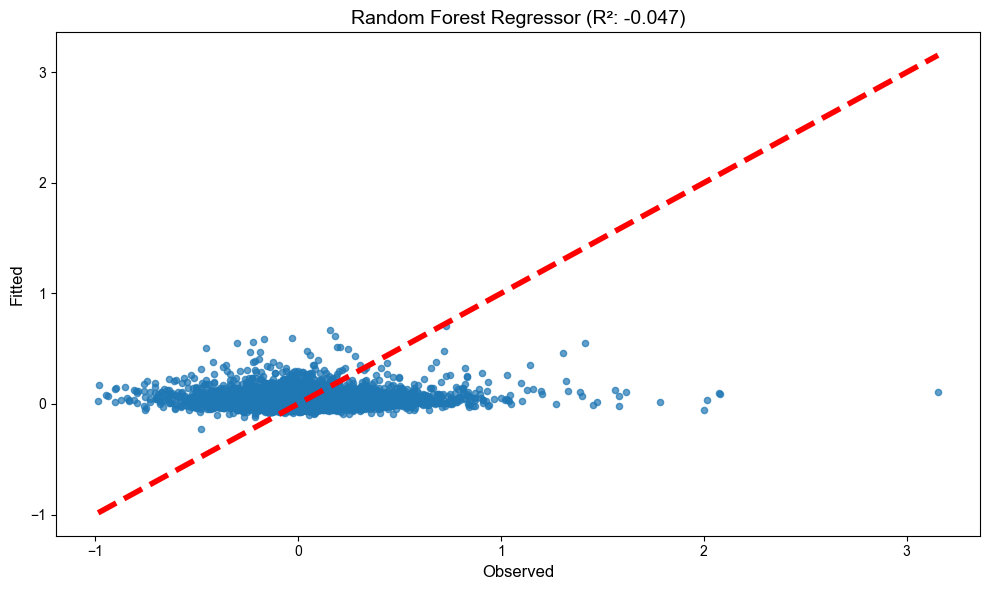

KeyboardInterrupt: 

In [41]:
run_model_and_plot("Random Forest Regressor", RandomForestRegressor(n_jobs=-1, random_state=0), X_data, y_data, add_feature_importance=True, add_shap_analysis=True)

Random Forest Regressor - R²: 0.885, MAE: 0.034, RMSE: 0.057


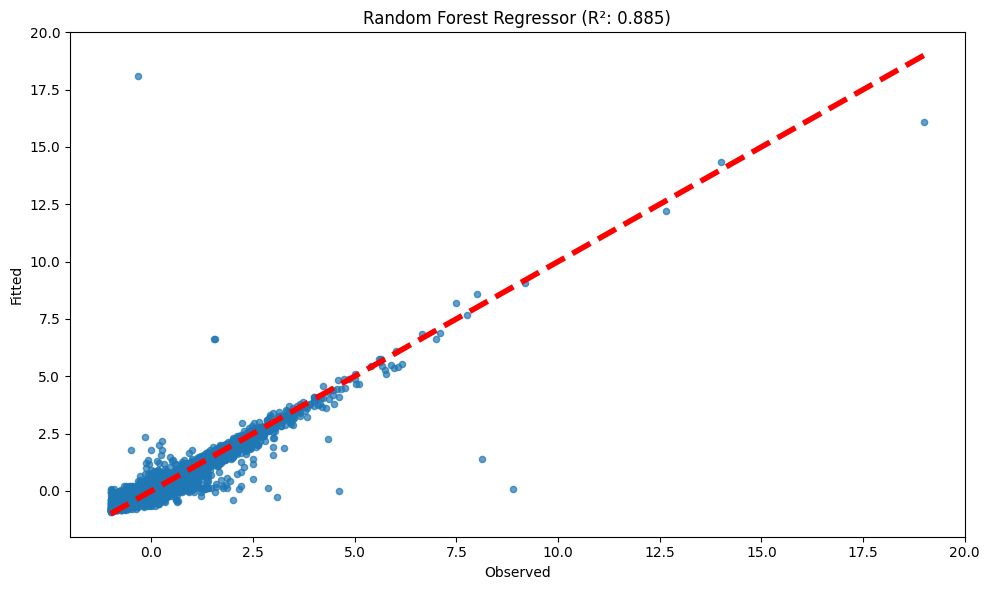

: 

In [5]:
run_model_and_plot("Random Forest Regressor", RandomForestRegressor(n_jobs=-1), X_data, y_data, save_image_as="random_forest.png", apply_pca=True, add_shap_analysis=True)

Random Forest Regressor - R²: 0.985, MAE: 0.001, RMSE: 0.021


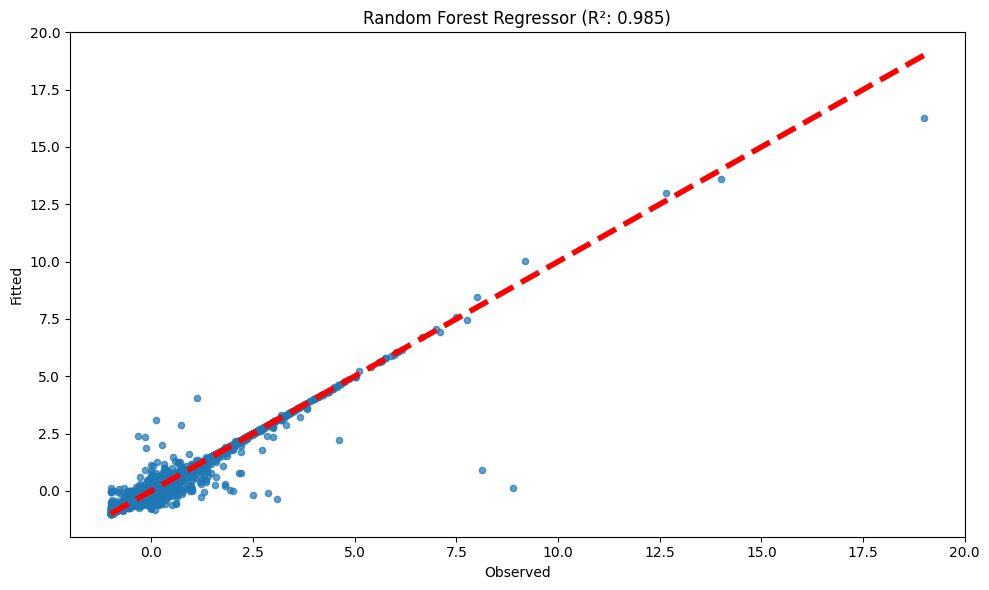

: 

In [5]:
run_model_and_plot("Random Forest Regressor", RandomForestRegressor(n_jobs=-1), X_data, y_data, save_image_as="random_forest.png", save_model_as="random_forest.model", add_shap_analysis=True)

Random Forest Regressor - R²: 0.985, MAE: 0.001, RMSE: 0.021
Successfully saved model.


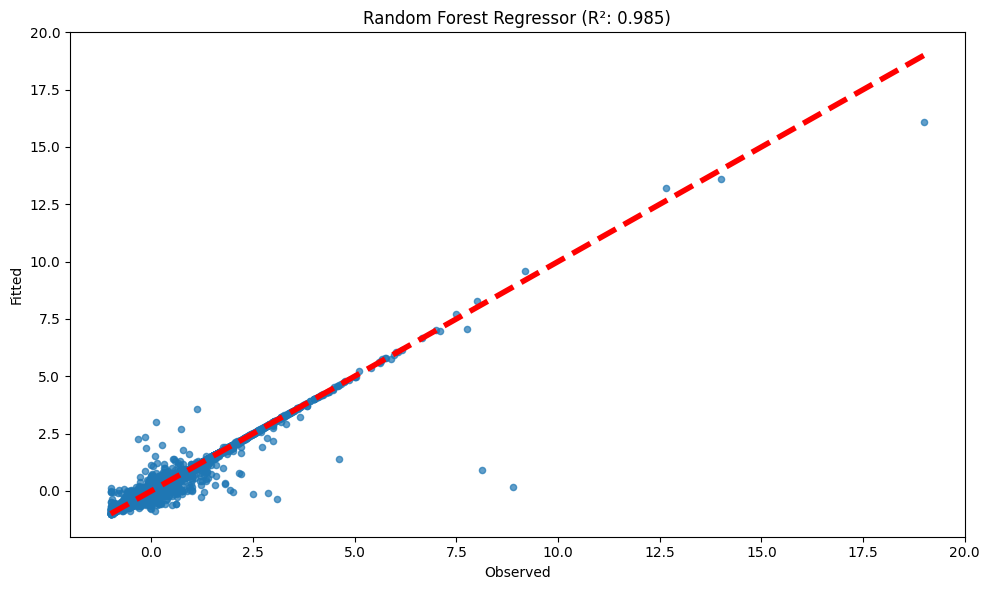

Successfully saved image.


In [7]:
run_model_and_plot("Random Forest Regressor", RandomForestRegressor(n_jobs=-1, random_state=0), X_data, y_data, save_image_as="random_forest.png", save_model_as="random_forest.model", run_cross_validation=False)